# Ten-Year Snow Cover Analysis (2015-2024)
## Scottish Highlands: Ben Nevis & Ben Macdui

This notebook downloads and analyzes snow cover data year-round from 2015-2024 for two mountain regions in the Scottish Highlands.

**Key Questions:**
- How has snow coverage changed over the past decade?
- Is snow coverage increasing or decreasing?
- What are the seasonal and inter-annual patterns?

**Workflow:**
1. Setup database and define Areas of Interest (AOIs)
2. Download Sentinel-2 imagery for all seasons (2015-2024)
3. Process snow masks using NDSI threshold
4. Visualize B03 band data with geographic coordinates
5. Analyze annual trends and determine direction of change

## Setup and Imports

In [1]:
import os
import sys
from pathlib import Path
from datetime import datetime

# Add parent directory to path for imports
sys.path.insert(0, str(Path.cwd().parent))

# Imports
from data_handler.aoi import get_aois
from data_handler.discovery import create_sh_config, find_sentinel_products
from data_handler.download import download_product
from data_handler.notebook_utils import create_aoi_map
from data_handler.demo_utils import (
    setup_database_and_aois,
    load_b03_images_from_db,
    plot_b03_with_coordinates,
    compute_snow_masks_for_aoi,
    analyze_snow_trends
)
from data_handler.repositories import AOIRepository, SentinelProductRepository, DownloadStatusRepository
from data_handler.models import SentinelProduct, DownloadStatus
from shapely.geometry import box

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set matplotlib style
plt.style.use('seaborn-v0_8-darkgrid')

print("✓ Imports successful")

✓ Imports successful


## 1. Define Areas of Interest (AOIs)

We monitor two mountain regions in the Scottish Highlands:
- **Ben Nevis** (56.7969°N, 5.0036°W) - Highest peak in the British Isles
- **Ben Macdui** (57.0704°N, 3.6691°W) - Second highest peak

Each AOI is a 10km × 10km bounding box centered on the mountain peak.

In [2]:
# Load AOI definitions
aois_gdf = get_aois()
print(f"Loaded {len(aois_gdf)} Areas of Interest:")
print()
for idx, row in aois_gdf.iterrows():
    print(f"  {row['name']}:")
    print(f"    Center: {row['center_lat']:.4f}°N, {row['center_lon']:.4f}°E")
    print(f"    Size: {row['size_km']} km × {row['size_km']} km")
    bounds = row['geometry'].bounds
    print(f"    Bounding box: ({bounds[0]:.4f}, {bounds[1]:.4f}) to ({bounds[2]:.4f}, {bounds[3]:.4f})")
    print()

Loaded 2 Areas of Interest:

  Ben Nevis:
    Center: 56.7969°N, -5.0036°E
    Size: 10.0 km × 10.0 km
    Bounding box: (-5.0856, 56.7520) to (-4.9216, 56.8418)

  Ben Macdui:
    Center: 57.0704°N, -3.6691°E
    Size: 10.0 km × 10.0 km
    Bounding box: (-3.7517, 57.0255) to (-3.5865, 57.1153)



In [3]:
# Display AOIs on interactive map
aoi_map = create_aoi_map(aois_gdf)
aoi_map

## 2. Initialize Database and Configuration

Create database schema and insert AOI definitions.

In [4]:
# Setup database
db_path = "../data/ten_year_analysis.db"
session, aoi_records = setup_database_and_aois(db_path=db_path)

print(f"✓ Database initialized: {db_path}")
print(f"✓ Loaded {len(aoi_records)} AOIs into database")

✓ Database initialized: ../data/ten_year_analysis.db
✓ Loaded 2 AOIs into database


In [5]:
# Create SentinelHub configuration
# Requires environment variables: SH_CLIENT_ID, SH_CLIENT_SECRET
try:
    config = create_sh_config()
    print("✓ SentinelHub configuration created")
except ValueError as e:
    print(f"⚠ Warning: {e}")
    print("Set credentials with: export SH_CLIENT_ID='...' and export SH_CLIENT_SECRET='...'")
    config = None

✓ SentinelHub configuration created


## 3. Download Year-Round Data for Ten Years

We'll download Sentinel-2 imagery for the complete years:
- **2015-2024** (Jan 1 - Dec 31 for each year)

**Cloud cover threshold:** 50%  
**Note:** Sentinel-2A launched June 23, 2015, so 2015 data starts mid-year. This will download a large amount of data and take significant time.

In [6]:
# Skip download if config is not available
if config is None:
    print("⚠ Skipping download - no SentinelHub configuration available")
    print("Using existing data in database if available")
else:
    # Download data for each full year (2015-2024)
    # Note: Sentinel-2A launched June 2015, so 2015 data starts mid-year
    years = [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]
    max_cloud_cover = 50.0
    
    all_stats = {}
    
    # Get repositories
    aoi_repo = AOIRepository(session)
    product_repo = SentinelProductRepository(session)
    status_repo = DownloadStatusRepository(session)
    
    for year in years:
        print(f"\n{'='*80}")
        print(f"YEAR {year}")
        print(f"{'='*80}")
        
        # Define date range for full year
        # For 2015, start from June 23 (Sentinel-2A launch)
        if year == 2015:
            start_date = datetime(2015, 6, 23)
        else:
            start_date = datetime(year, 1, 1)
        end_date = datetime(year, 12, 31, 23, 59, 59)
        
        year_stats = {
            'products_discovered': 0,
            'products_inserted': 0,
            'products_downloaded': 0,
            'products_failed': 0
        }
        
        # Process each AOI
        for aoi in aoi_records:
            print(f"\n  Processing AOI: {aoi.name}")
            print(f"    Center: ({aoi.center_lat:.4f}°N, {aoi.center_lon:.4f}°E)")
            print(f"    Date range: {start_date.date()} to {end_date.date()}")
            print(f"    Cloud threshold: {max_cloud_cover}%")
            
            # Create search polygon
            search_polygon = box(
                aoi.center_lon - 0.05,
                aoi.center_lat - 0.05,
                aoi.center_lon + 0.05,
                aoi.center_lat + 0.05
            )
            
            # Discover products
            print(f"    Discovering products...")
            try:
                products_df = find_sentinel_products(
                    config=config,
                    bbox=search_polygon,
                    start_date=start_date,
                    end_date=end_date,
                    max_cloud_cover=max_cloud_cover
                )
                year_stats['products_discovered'] += len(products_df)
                print(f"    ✓ Found {len(products_df)} products")
            except Exception as e:
                print(f"    ✗ Discovery failed: {str(e)[:100]}")
                continue
            
            if len(products_df) == 0:
                print(f"    No products found")
                continue
            
            # Insert products into database
            print(f"    Inserting products into database...")
            inserted_count = 0
            for _, row in products_df.iterrows():
                # Check if product already exists
                existing = product_repo.get_by_product_id(row['product_id'])
                if existing:
                    continue
                
                # Create product record
                product = product_repo.create(
                    product_id=row['product_id'],
                    aoi_id=aoi.id,
                    acquisition_dt=row['date'],
                    cloud_cover=row['cloud_cover'],
                    geometry=str(row.get('geometry', '{}'))
                )
                
                # Create download status
                status_repo.create(product_id=product.id, status='pending')
                inserted_count += 1
            
            year_stats['products_inserted'] += inserted_count
            print(f"    ✓ Inserted {inserted_count} new products")
            
            # Download products
            if inserted_count > 0:
                print(f"    Downloading products...")
                
                # Get pending downloads for this AOI and year
                pending = session.query(DownloadStatus).join(SentinelProduct).filter(
                    SentinelProduct.aoi_id == aoi.id,
                    SentinelProduct.acquisition_dt >= start_date,
                    SentinelProduct.acquisition_dt <= end_date,
                    DownloadStatus.status == 'pending'
                ).all()
                
                for idx, status in enumerate(pending, 1):
                    product = status.product
                    print(f"      [{idx}/{len(pending)}] {product.acquisition_dt.date()}...", end=" ")
                    
                    success, error, file_path = download_product(
                        session,
                        product.id,
                        config=config
                    )
                    
                    if success:
                        print(f"✓")
                        year_stats['products_downloaded'] += 1
                    else:
                        print(f"✗ {error[:40] if error else 'Error'}")
                        year_stats['products_failed'] += 1
        
        all_stats[year] = year_stats
        print(f"\n  Year {year} Summary:")
        print(f"    Discovered: {year_stats['products_discovered']} products")
        print(f"    Inserted: {year_stats['products_inserted']} products")
        print(f"    Downloaded: {year_stats['products_downloaded']} products")
        print(f"    Failed: {year_stats['products_failed']} products")
    
    # Overall summary
    print(f"\n{'='*80}")
    print("OVERALL SUMMARY (2015-2024)")
    print(f"{'='*80}")
    total_discovered = sum(s['products_discovered'] for s in all_stats.values())
    total_inserted = sum(s['products_inserted'] for s in all_stats.values())
    total_downloaded = sum(s['products_downloaded'] for s in all_stats.values())
    total_failed = sum(s['products_failed'] for s in all_stats.values())
    print(f"  Total discovered: {total_discovered} products")
    print(f"  Total inserted: {total_inserted} products")
    print(f"  Total downloaded: {total_downloaded} products")
    print(f"  Total failed: {total_failed} products")


YEAR 2015

  Processing AOI: Ben Nevis
    Center: (56.7969°N, -5.0036°E)
    Date range: 2015-06-23 to 2015-12-31
    Cloud threshold: 50.0%
    Discovering products...
    ✓ Found 2 products
    Inserting products into database...
    ✓ Inserted 2 new products
      [1/2] 2015-09-29... ✓
      [2/2] 2015-09-29... ✓

  Processing AOI: Ben Macdui
    Center: (57.0704°N, -3.6691°E)
    Date range: 2015-06-23 to 2015-12-31
    Cloud threshold: 50.0%
    Discovering products...
    ✓ Found 3 products
    Inserting products into database...
    ✓ Inserted 3 new products
      [1/3] 2015-12-08... ✓
      [2/3] 2015-09-29... ✓
      [3/3] 2015-09-19... ✓

  Year 2015 Summary:
    Discovered: 5 products
    Inserted: 5 products
    Downloaded: 5 products
    Failed: 0 products

YEAR 2016

  Processing AOI: Ben Nevis
    Center: (56.7969°N, -5.0036°E)
    Date range: 2016-01-01 to 2016-12-31
    Cloud threshold: 50.0%
    Discovering products...
    ✓ Found 17 products
    Inserting products 

## 4. Visualize B03 Band Data (Green Band)

Display example B03 (green) band images with geographic coordinates (latitude/longitude).

Loaded 6 B03 images for Ben Nevis


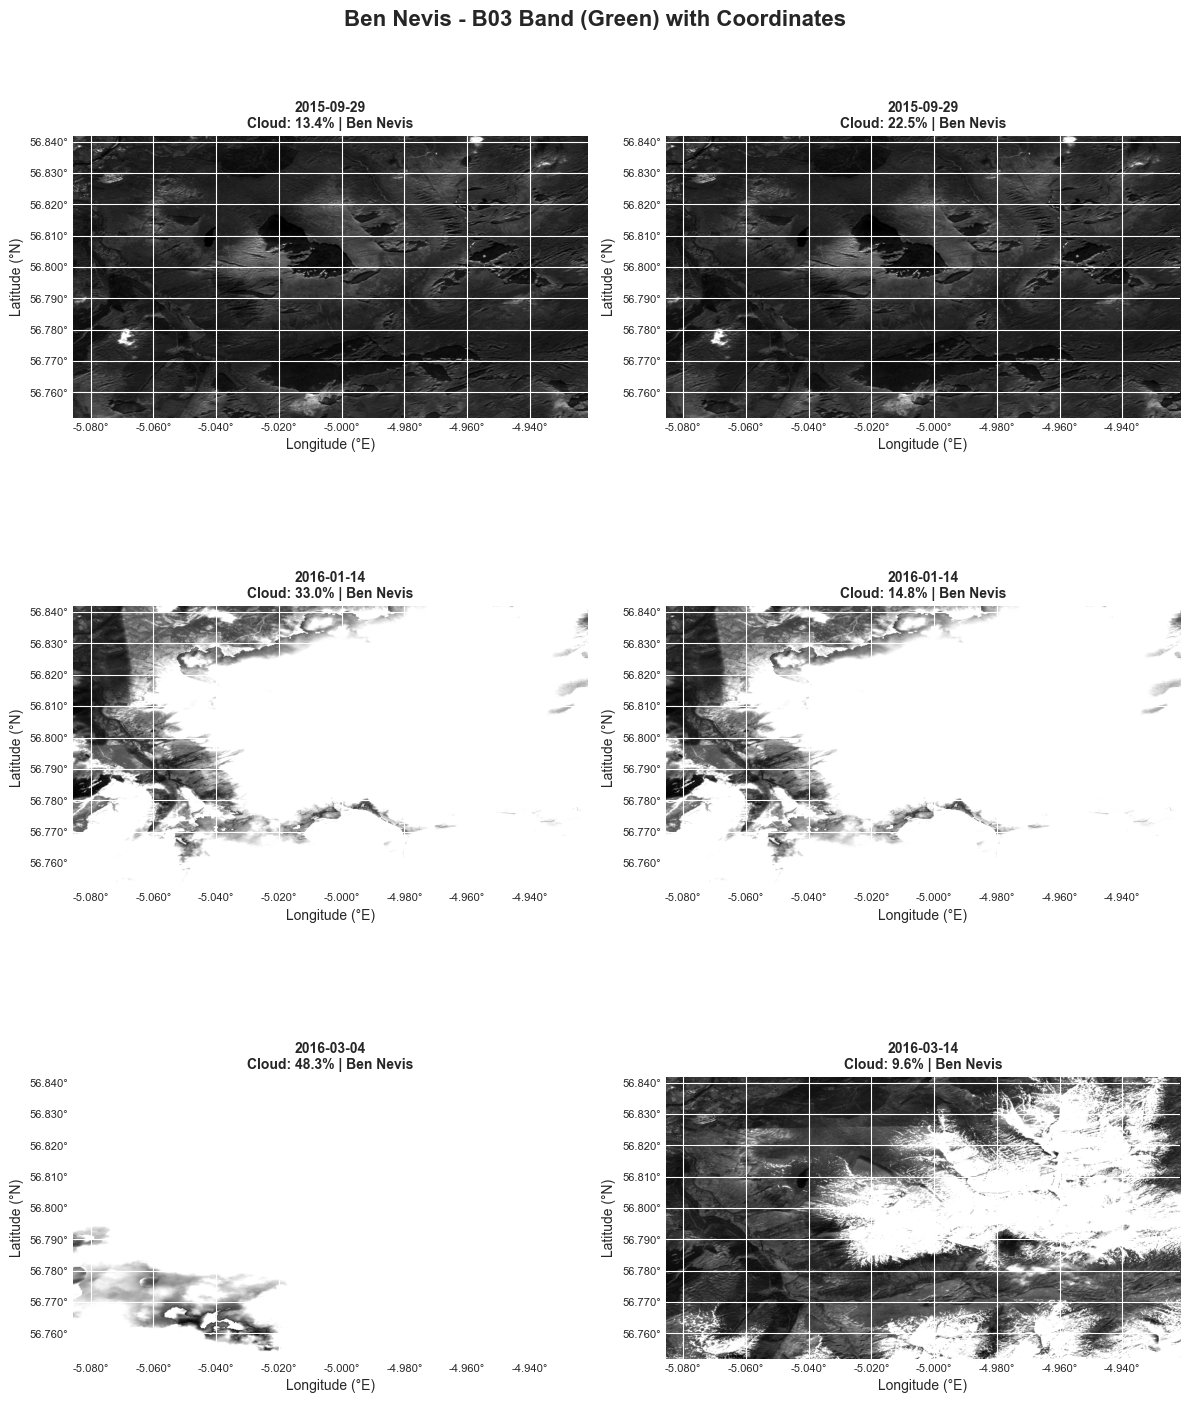

In [7]:
# Load B03 images for Ben Nevis
ben_nevis_images = load_b03_images_from_db(session, aoi_name='Ben Nevis', limit=6)
print(f"Loaded {len(ben_nevis_images)} B03 images for Ben Nevis")

if len(ben_nevis_images) > 0:
    fig = plot_b03_with_coordinates(
        ben_nevis_images,
        title="Ben Nevis - B03 Band (Green) with Coordinates",
        ncols=2,
        brightness_factor=3.0
    )
    plt.show()
else:
    print("No images available for Ben Nevis")

Loaded 6 B03 images for Ben Macdui


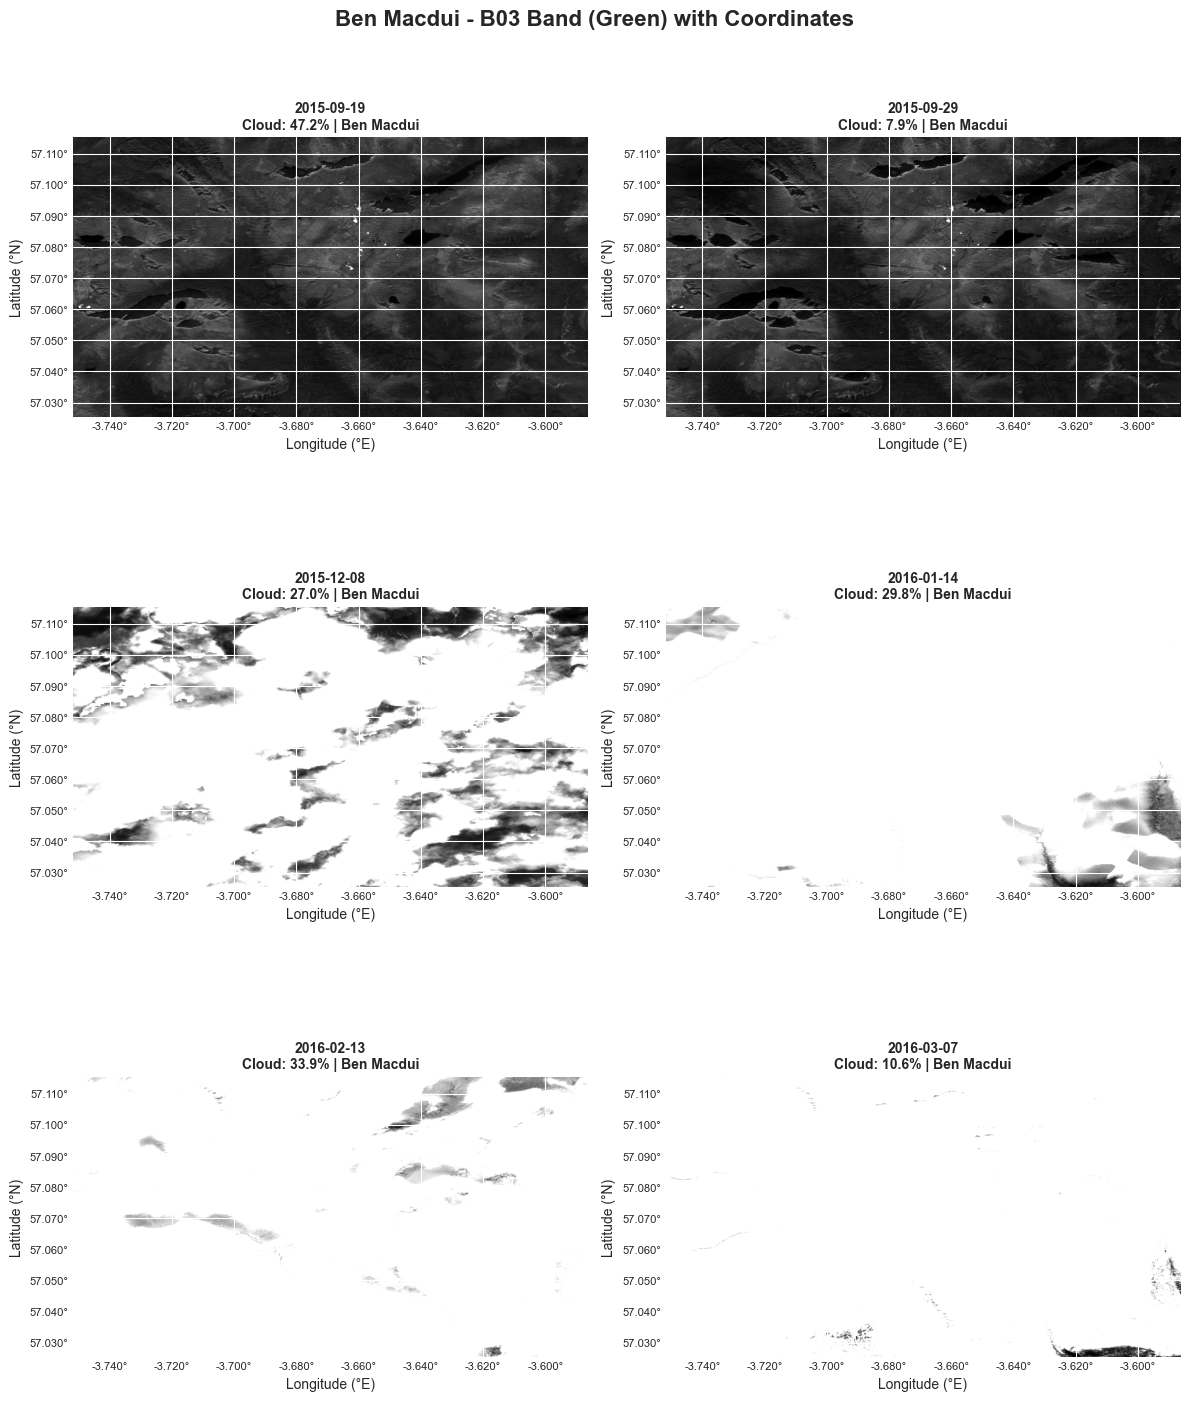

In [8]:
# Load B03 images for Ben Macdui
ben_macdui_images = load_b03_images_from_db(session, aoi_name='Ben Macdui', limit=6)
print(f"Loaded {len(ben_macdui_images)} B03 images for Ben Macdui")

if len(ben_macdui_images) > 0:
    fig = plot_b03_with_coordinates(
        ben_macdui_images,
        title="Ben Macdui - B03 Band (Green) with Coordinates",
        ncols=2,
        brightness_factor=3.0
    )
    plt.show()
else:
    print("No images available for Ben Macdui")

## 5. Process Snow Masks

Generate binary snow masks using NDSI (Normalized Difference Snow Index):

$$NDSI = \frac{B03 - B11}{B03 + B11}$$

Pixels with NDSI > 0.4 are classified as snow.

In [9]:
# Process snow masks for Ben Nevis
ben_nevis_stats = compute_snow_masks_for_aoi(
    session=session,
    aoi_name='Ben Nevis',
    ndsi_threshold=0.4,
    save_masks=True
)

print(f"\nBen Nevis Summary:")
print(f"  Processed: {ben_nevis_stats['products_processed']} products")
print(f"  Failed: {ben_nevis_stats['products_failed']} products")
print(f"  Average snow coverage: {ben_nevis_stats['avg_snow_pct']:.1f}%")


Computing snow masks for: Ben Nevis
  NDSI threshold: 0.4
  Save masks: True
  Found 416 downloaded products
  [1/416] 2015-09-29... ✓ Snow: 0.0%
  [2/416] 2015-09-29... ✓ Snow: 0.0%
  [3/416] 2016-01-14... ✓ Snow: 74.8%
  [4/416] 2016-01-14... ✓ Snow: 74.8%
  [5/416] 2016-03-04... ✓ Snow: 51.8%
  [6/416] 2016-03-14... ✓ Snow: 27.0%
  [7/416] 2016-03-14... ✓ Snow: 27.0%
  [8/416] 2016-03-17... ✓ Snow: 22.1%
  [9/416] 2016-04-26... ✓ Snow: 8.8%
  [10/416] 2016-05-26... ✓ Snow: 0.9%
  [11/416] 2016-06-02... ✓ Snow: 1.0%
  [12/416] 2016-06-02... ✓ Snow: 1.0%
  [13/416] 2016-06-05... ✓ Snow: 0.1%
  [14/416] 2016-06-05... ✓ Snow: 0.1%
  [15/416] 2016-08-24... ✓ Snow: 0.0%
  [16/416] 2016-08-24... ✓ Snow: 0.0%
  [17/416] 2016-10-13... ✓ Snow: 2.2%
  [18/416] 2016-10-13... ✓ Snow: 2.2%
  [19/416] 2016-10-23... ✓ Snow: 0.1%
  [20/416] 2017-01-01... ✓ Snow: 26.7%
  [21/416] 2017-01-01... ✓ Snow: 26.7%
  [22/416] 2017-02-27... ✓ Snow: 75.4%
  [23/416] 2017-03-02... ✓ Snow: 99.8%
  [24/416] 2017

In [10]:
# Process snow masks for Ben Macdui
ben_macdui_stats = compute_snow_masks_for_aoi(
    session=session,
    aoi_name='Ben Macdui',
    ndsi_threshold=0.4,
    save_masks=True
)

print(f"\nBen Macdui Summary:")
print(f"  Processed: {ben_macdui_stats['products_processed']} products")
print(f"  Failed: {ben_macdui_stats['products_failed']} products")
print(f"  Average snow coverage: {ben_macdui_stats['avg_snow_pct']:.1f}%")


Computing snow masks for: Ben Macdui
  NDSI threshold: 0.4
  Save masks: True
  Found 233 downloaded products
  [1/233] 2015-09-19... ✓ Snow: 0.0%
  [2/233] 2015-09-29... ✓ Snow: 0.0%
  [3/233] 2015-12-08... ✓ Snow: 19.3%
  [4/233] 2016-01-14... ✓ Snow: 74.1%
  [5/233] 2016-02-13... ✓ Snow: 96.8%
  [6/233] 2016-03-07... ✓ Snow: 99.1%
  [7/233] 2016-03-14... ✓ Snow: 71.3%
  [8/233] 2016-03-17... ✓ Snow: 62.2%
  [9/233] 2016-06-05... ✓ Snow: 1.7%
  [10/233] 2016-08-24... ✓ Snow: 0.0%
  [11/233] 2016-09-10... ✓ Snow: 0.0%
  [12/233] 2016-09-20... ✓ Snow: 0.0%
  [13/233] 2016-10-10... ✓ Snow: 0.0%
  [14/233] 2016-11-12... ✓ Snow: 63.0%
  [15/233] 2016-11-19... ✓ Snow: 93.3%
  [16/233] 2017-02-10... ✓ Snow: 84.0%
  [17/233] 2017-02-17... ✓ Snow: 40.0%
  [18/233] 2017-02-27... ✓ Snow: 91.2%
  [19/233] 2017-03-09... ✓ Snow: 62.1%
  [20/233] 2017-05-01... ✓ Snow: 26.3%
  [21/233] 2017-05-06... ✓ Snow: 7.6%
  [22/233] 2017-05-31... ✓ Snow: 0.1%
  [23/233] 2017-06-20... ✓ Snow: 0.0%
  [24/233] 

## 6. Load and Prepare Trend Data

Extract time series data for analysis.

In [11]:
# Get trend data for all AOIs
trends_df = analyze_snow_trends(session)

print(f"Loaded {len(trends_df)} data points")
if len(trends_df) > 0:
    print(f"Date range: {trends_df['date'].min()} to {trends_df['date'].max()}")
    print(f"AOIs: {trends_df['aoi_name'].unique().tolist()}")
    print(f"\nFirst few records:")
    print(trends_df.head())
    
    # Add temporal columns for analysis
    trends_df['year'] = pd.to_datetime(trends_df['date']).dt.year
    trends_df['month'] = pd.to_datetime(trends_df['date']).dt.month
    trends_df['day_of_year'] = pd.to_datetime(trends_df['date']).dt.dayofyear

Loaded 649 data points
Date range: 2015-09-19 11:45:24.577000 to 2024-12-25 11:45:23.663000
AOIs: ['Ben Macdui', 'Ben Nevis']

First few records:
                     date    aoi_name   snow_pct  snow_pixels  total_pixels  \
0 2015-09-19 11:45:24.577  Ben Macdui   0.029816          305       1022950   
1 2015-09-29 11:45:24.555  Ben Macdui   0.019063          195       1022950   
2 2015-09-29 11:45:30.015   Ben Nevis   0.023131          235       1015964   
3 2015-09-29 11:45:40.679   Ben Nevis   0.023131          235       1015964   
4 2015-12-08 11:45:21.292  Ben Macdui  19.294785       197376       1022950   

   cloud_cover  
0        47.25  
1         7.91  
2        13.37  
3        22.53  
4        27.00  


## 7. Continuous Time Series

Visualize snow coverage across the entire decade.

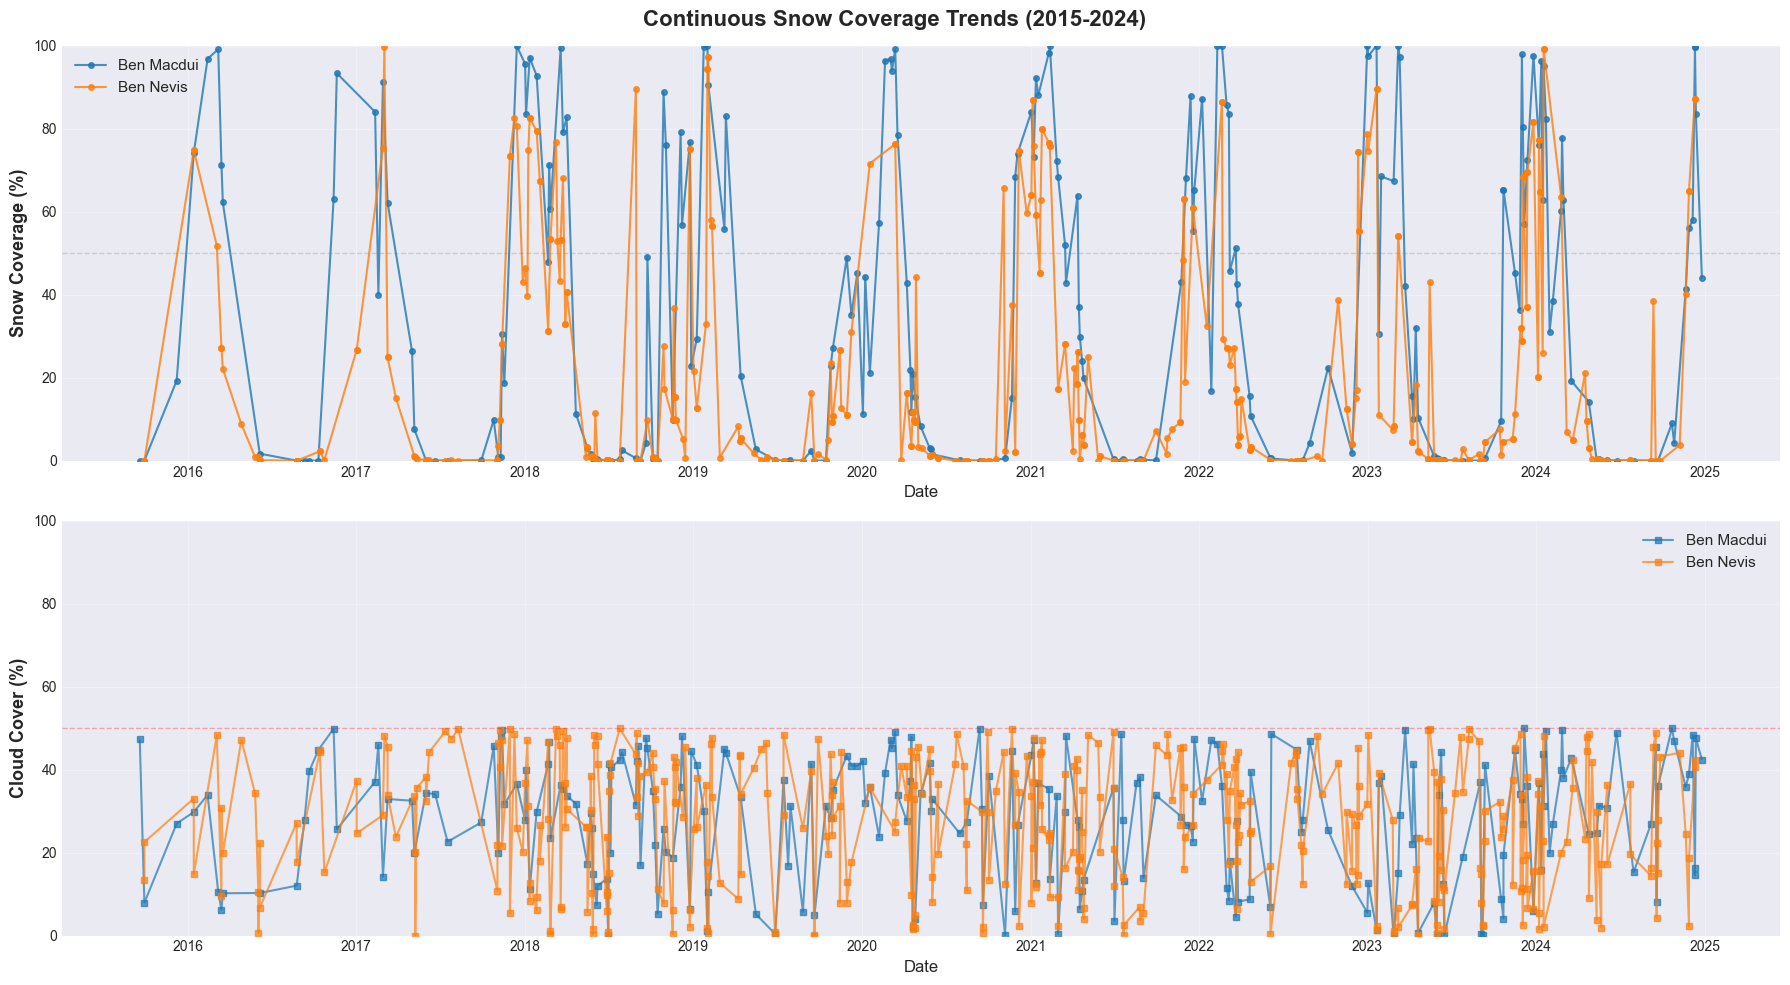

In [12]:
# Plot continuous time series for entire period
if len(trends_df) > 0:
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 10))
    fig.suptitle('Continuous Snow Coverage Trends (2015-2024)', fontsize=16, fontweight='bold')
    
    # Plot 1: Snow coverage percentage over time
    for aoi_name in sorted(trends_df['aoi_name'].unique()):
        aoi_data = trends_df[trends_df['aoi_name'] == aoi_name].sort_values('date')
        ax1.plot(aoi_data['date'], aoi_data['snow_pct'],
                marker='o', label=aoi_name, linewidth=1.5, markersize=4, alpha=0.8)
    
    ax1.set_ylabel('Snow Coverage (%)', fontsize=13, fontweight='bold')
    ax1.set_xlabel('Date', fontsize=12)
    ax1.grid(True, alpha=0.3)
    ax1.legend(fontsize=11)
    ax1.set_ylim(0, 100)
    ax1.axhline(y=50, color='gray', linestyle='--', alpha=0.3, linewidth=1)
    
    # Plot 2: Cloud cover over time
    for aoi_name in sorted(trends_df['aoi_name'].unique()):
        aoi_data = trends_df[trends_df['aoi_name'] == aoi_name].sort_values('date')
        ax2.plot(aoi_data['date'], aoi_data['cloud_cover'],
                marker='s', label=aoi_name, linewidth=1.5, markersize=4, alpha=0.7)
    
    ax2.set_ylabel('Cloud Cover (%)', fontsize=13, fontweight='bold')
    ax2.set_xlabel('Date', fontsize=12)
    ax2.grid(True, alpha=0.3)
    ax2.legend(fontsize=11)
    ax2.set_ylim(0, 100)
    ax2.axhline(y=50, color='red', linestyle='--', alpha=0.3, linewidth=1, label='Threshold')
    
    plt.tight_layout()
    plt.show()
else:
    print("No trend data available")

## 8. **KEY ANALYSIS: Is Snow Coverage Increasing or Decreasing?**

This section answers the critical question: What is the direction and magnitude of change in snow coverage over the past decade?

We use linear regression to quantify trends and determine statistical significance.


DECADAL TREND ANALYSIS (2015-2024)

Ben Macdui:
  Slope: 2.0151% per year
  Standard Error: ±1.1051%
  R-squared: 0.2936 (fit quality)
  P-value: 0.105704
  Statistical Significance: NO ✗ (α=0.05)
  Trend Direction: INCREASING
  Total Change (2015-2024): +18.14%
  Mean Snow Coverage: 34.03%

Ben Nevis:
  Slope: 1.3443% per year
  Standard Error: ±0.8146%
  R-squared: 0.2540 (fit quality)
  P-value: 0.137476
  Statistical Significance: NO ✗ (α=0.05)
  Trend Direction: INCREASING
  Total Change (2015-2024): +12.10%
  Mean Snow Coverage: 19.62%



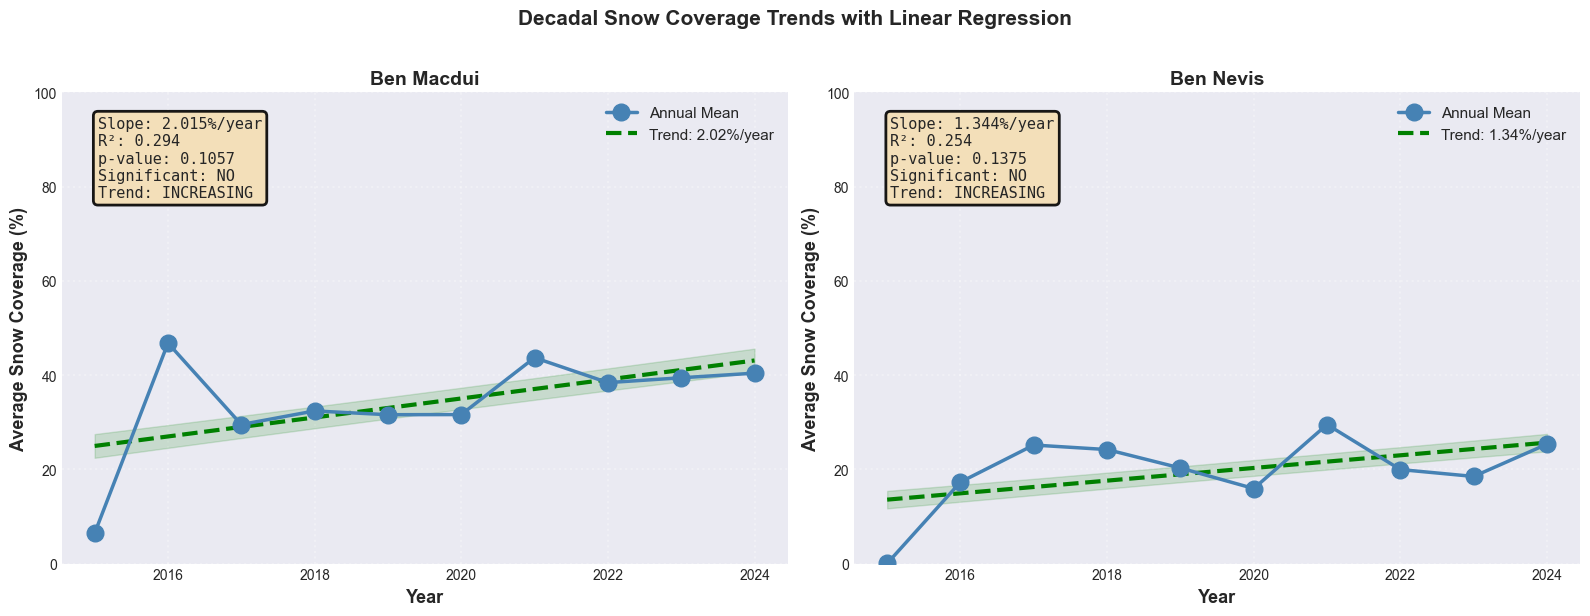

INTERPRETATION:
  - Positive slope = snow coverage is INCREASING
  - Negative slope = snow coverage is DECREASING
  - P-value < 0.05 = trend is statistically significant
  - R² closer to 1 = stronger linear relationship


In [13]:
if len(trends_df) > 0:
    # Calculate annual averages
    annual_means = trends_df.groupby(['aoi_name', 'year'])['snow_pct'].mean().reset_index()
    
    # Plot annual averages with trend lines
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    print("\n" + "="*80)
    print("DECADAL TREND ANALYSIS (2015-2024)")
    print("="*80 + "\n")
    
    for idx, aoi_name in enumerate(sorted(trends_df['aoi_name'].unique())):
        ax = axes[idx]
        aoi_annual = annual_means[annual_means['aoi_name'] == aoi_name]
        
        # Plot annual means
        ax.plot(aoi_annual['year'], aoi_annual['snow_pct'], 
               marker='o', linewidth=2.5, markersize=12, label='Annual Mean',
               color='steelblue', zorder=3)
        
        # Calculate and plot linear trend
        x = aoi_annual['year'].values
        y = aoi_annual['snow_pct'].values
        slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
        trend_line = slope * x + intercept
        
        # Determine trend direction and significance
        trend_direction = 'INCREASING' if slope > 0 else 'DECREASING'
        trend_color = 'green' if slope > 0 else 'red'
        is_significant = p_value < 0.05
        
        ax.plot(x, trend_line, '--', linewidth=3, color=trend_color,
               label=f'Trend: {slope:.2f}%/year', zorder=2)
        
        # Add confidence interval (95%)
        predict_error = 1.96 * std_err * np.sqrt(1 + 1/len(x) + (x - x.mean())**2 / ((x - x.mean())**2).sum())
        ax.fill_between(x, trend_line - predict_error, trend_line + predict_error,
                        color=trend_color, alpha=0.15, zorder=1)
        
        # Add text box with statistics
        textstr = f'Slope: {slope:.3f}%/year\n'
        textstr += f'R²: {r_value**2:.3f}\n'
        textstr += f'p-value: {p_value:.4f}\n'
        textstr += f'Significant: {"YES" if is_significant else "NO"}\n'
        textstr += f'Trend: {trend_direction}'
        
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.9, edgecolor='black', linewidth=2)
        ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=11,
               verticalalignment='top', bbox=props, family='monospace')
        
        ax.set_xlabel('Year', fontsize=13, fontweight='bold')
        ax.set_ylabel('Average Snow Coverage (%)', fontsize=13, fontweight='bold')
        ax.set_title(f'{aoi_name}', fontsize=14, fontweight='bold')
        ax.grid(True, alpha=0.3, linestyle=':', linewidth=1.5)
        ax.legend(fontsize=11, loc='upper right')
        ax.set_ylim(0, max(100, y.max() * 1.15))
        
        # Print detailed statistics
        print(f"{aoi_name}:")
        print(f"  Slope: {slope:.4f}% per year")
        print(f"  Standard Error: ±{std_err:.4f}%")
        print(f"  R-squared: {r_value**2:.4f} (fit quality)")
        print(f"  P-value: {p_value:.6f}")
        print(f"  Statistical Significance: {'YES ✓' if is_significant else 'NO ✗'} (α=0.05)")
        print(f"  Trend Direction: {trend_direction}")
        total_change = slope * (x[-1] - x[0])
        print(f"  Total Change (2015-2024): {total_change:+.2f}%")
        print(f"  Mean Snow Coverage: {y.mean():.2f}%")
        print()
    
    plt.suptitle('Decadal Snow Coverage Trends with Linear Regression', 
                fontsize=15, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
    
    print("="*80)
    print("INTERPRETATION:")
    print("  - Positive slope = snow coverage is INCREASING")
    print("  - Negative slope = snow coverage is DECREASING")
    print("  - P-value < 0.05 = trend is statistically significant")
    print("  - R² closer to 1 = stronger linear relationship")
    print("="*80)
else:
    print("No data available for trend analysis")

## 9. Box Plot Distribution by Year

Visualize the full distribution of snow coverage measurements for each year.

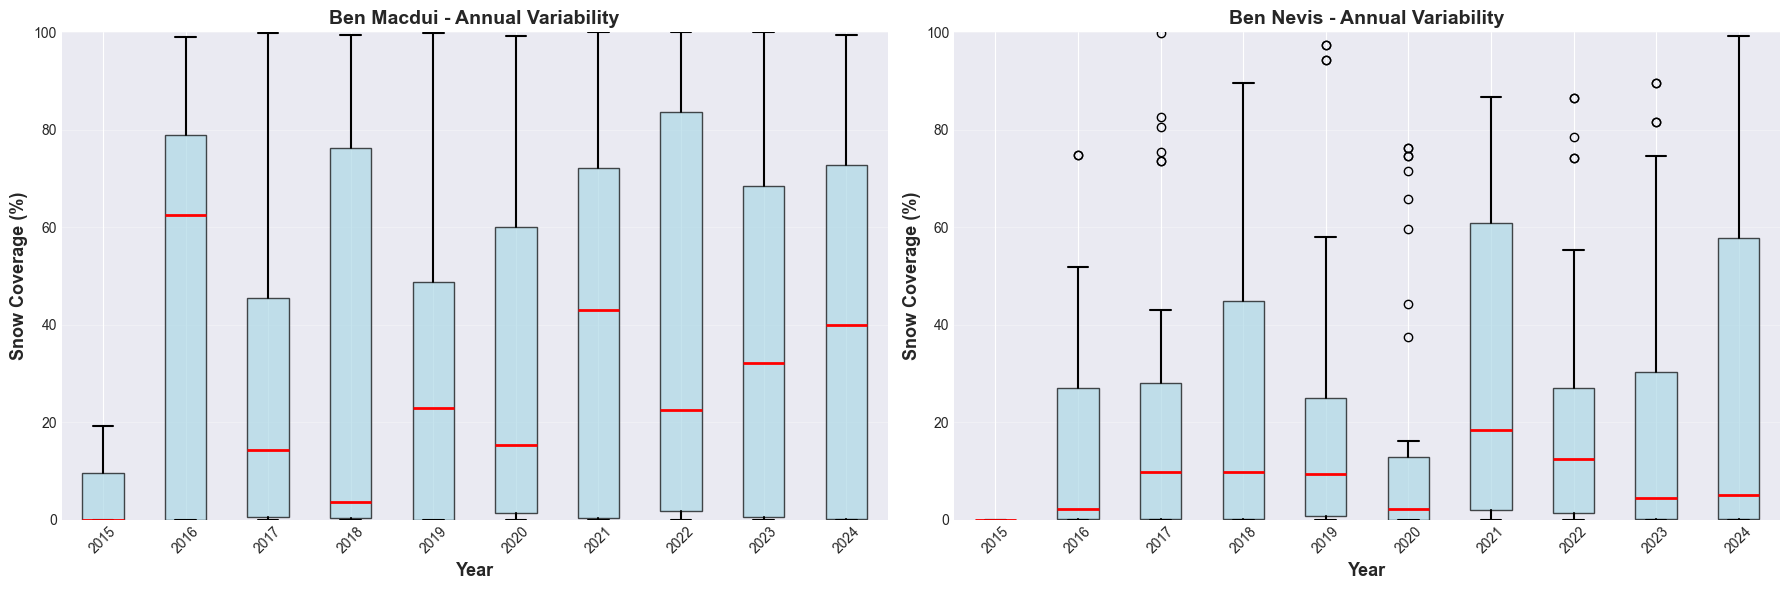

In [14]:
if len(trends_df) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))
    
    for idx, aoi_name in enumerate(sorted(trends_df['aoi_name'].unique())):
        ax = axes[idx]
        aoi_data = trends_df[trends_df['aoi_name'] == aoi_name]
        
        # Create box plot
        years_sorted = sorted(aoi_data['year'].unique())
        data_by_year = [aoi_data[aoi_data['year'] == year]['snow_pct'].values 
                       for year in years_sorted]
        
        bp = ax.boxplot(data_by_year, labels=years_sorted, patch_artist=True,
                        medianprops=dict(color='red', linewidth=2),
                        boxprops=dict(facecolor='lightblue', alpha=0.7),
                        whiskerprops=dict(linewidth=1.5),
                        capprops=dict(linewidth=1.5))
        
        ax.set_xlabel('Year', fontsize=13, fontweight='bold')
        ax.set_ylabel('Snow Coverage (%)', fontsize=13, fontweight='bold')
        ax.set_title(f'{aoi_name} - Annual Variability', fontsize=14, fontweight='bold')
        ax.grid(True, alpha=0.3, axis='y')
        ax.set_ylim(0, 100)
        ax.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
else:
    print("No data available for box plot")

## 10. Seasonal Trend Analysis

Compare winter vs summer trends separately to see if different seasons show different patterns.


SEASONAL TREND ANALYSIS:

Ben Macdui:
  Winter trend: +2.598%/year (p=0.2545)
  Summer trend: -0.027%/year (p=0.5839)

Ben Nevis:
  Winter trend: -0.655%/year (p=0.5972)
  Summer trend: -0.203%/year (p=0.4548)



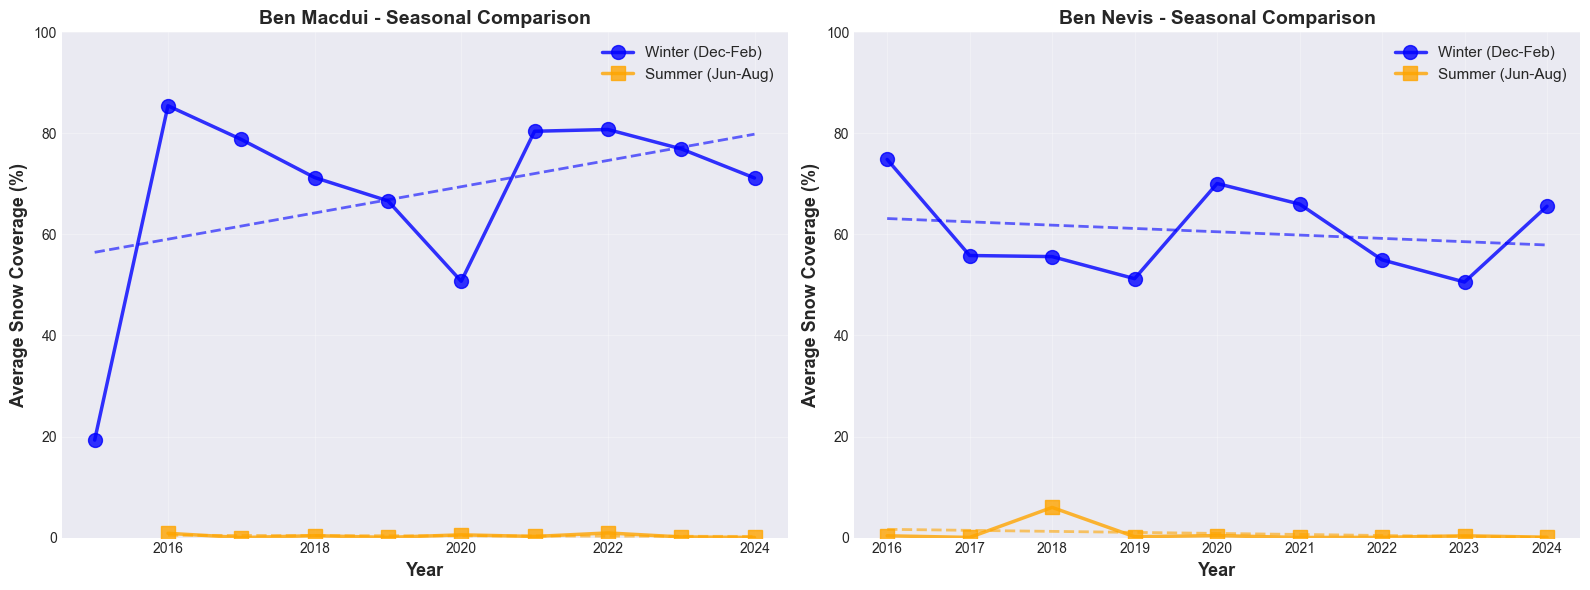

In [15]:
if len(trends_df) > 0:
    # Define seasons
    winter_months = [12, 1, 2]
    summer_months = [6, 7, 8]
    
    # Filter data
    winter_data = trends_df[trends_df['month'].isin(winter_months)]
    summer_data = trends_df[trends_df['month'].isin(summer_months)]
    
    # Calculate seasonal averages
    winter_annual = winter_data.groupby(['aoi_name', 'year'])['snow_pct'].mean().reset_index()
    summer_annual = summer_data.groupby(['aoi_name', 'year'])['snow_pct'].mean().reset_index()
    
    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    print("\nSEASONAL TREND ANALYSIS:\n")
    
    for idx, aoi_name in enumerate(sorted(trends_df['aoi_name'].unique())):
        ax = axes[idx]
        
        # Winter data
        winter_aoi = winter_annual[winter_annual['aoi_name'] == aoi_name]
        if len(winter_aoi) > 1:
            ax.plot(winter_aoi['year'], winter_aoi['snow_pct'], 
                   marker='o', linewidth=2.5, markersize=10, label='Winter (Dec-Feb)',
                   color='blue', alpha=0.8)
            
            # Winter trend
            x_w = winter_aoi['year'].values
            y_w = winter_aoi['snow_pct'].values
            slope_w, intercept_w, r_w, p_w, _ = stats.linregress(x_w, y_w)
            ax.plot(x_w, slope_w * x_w + intercept_w, '--', 
                   linewidth=2, color='blue', alpha=0.6)
        
        # Summer data
        summer_aoi = summer_annual[summer_annual['aoi_name'] == aoi_name]
        if len(summer_aoi) > 1:
            ax.plot(summer_aoi['year'], summer_aoi['snow_pct'], 
                   marker='s', linewidth=2.5, markersize=10, label='Summer (Jun-Aug)',
                   color='orange', alpha=0.8)
            
            # Summer trend
            x_s = summer_aoi['year'].values
            y_s = summer_aoi['snow_pct'].values
            slope_s, intercept_s, r_s, p_s, _ = stats.linregress(x_s, y_s)
            ax.plot(x_s, slope_s * x_s + intercept_s, '--', 
                   linewidth=2, color='orange', alpha=0.6)
        
        ax.set_xlabel('Year', fontsize=13, fontweight='bold')
        ax.set_ylabel('Average Snow Coverage (%)', fontsize=13, fontweight='bold')
        ax.set_title(f'{aoi_name} - Seasonal Comparison', fontsize=14, fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=11)
        ax.set_ylim(0, 100)
        
        # Print statistics
        print(f"{aoi_name}:")
        if len(winter_aoi) > 1:
            print(f"  Winter trend: {slope_w:+.3f}%/year (p={p_w:.4f})")
        if len(summer_aoi) > 1:
            print(f"  Summer trend: {slope_s:+.3f}%/year (p={p_s:.4f})")
        print()
    
    plt.tight_layout()
    plt.show()
else:
    print("No data available for seasonal analysis")

## 11. Monthly Patterns

Average snow coverage by month across all years.


Average Snow Coverage by Month (2015-2024):
                 snow_pct             
                     mean    std count
aoi_name   month                      
Ben Macdui 1        71.51  29.36    27
           2        75.66  20.78    20
           3        69.94  23.93    25
           4        25.52  18.96    20
           5         3.93   6.69    15
           6         0.37   0.50    17
           7         0.22   0.60    17
           8         0.53   1.32    10
           9         2.37  10.02    24
           10       20.34  28.08    16
           11       36.11  28.46    18
           12       69.80  24.56    24
Ben Nevis  1        60.99  26.65    44
           2        55.87  29.09    24
           3        31.41  23.96    41
           4        10.92  10.42    48
           5         2.67   7.83    38
           6         0.55   1.88    37
           7         0.13   0.53    26
           8         4.82  20.53    19
           9         2.46   7.24    34
           10      

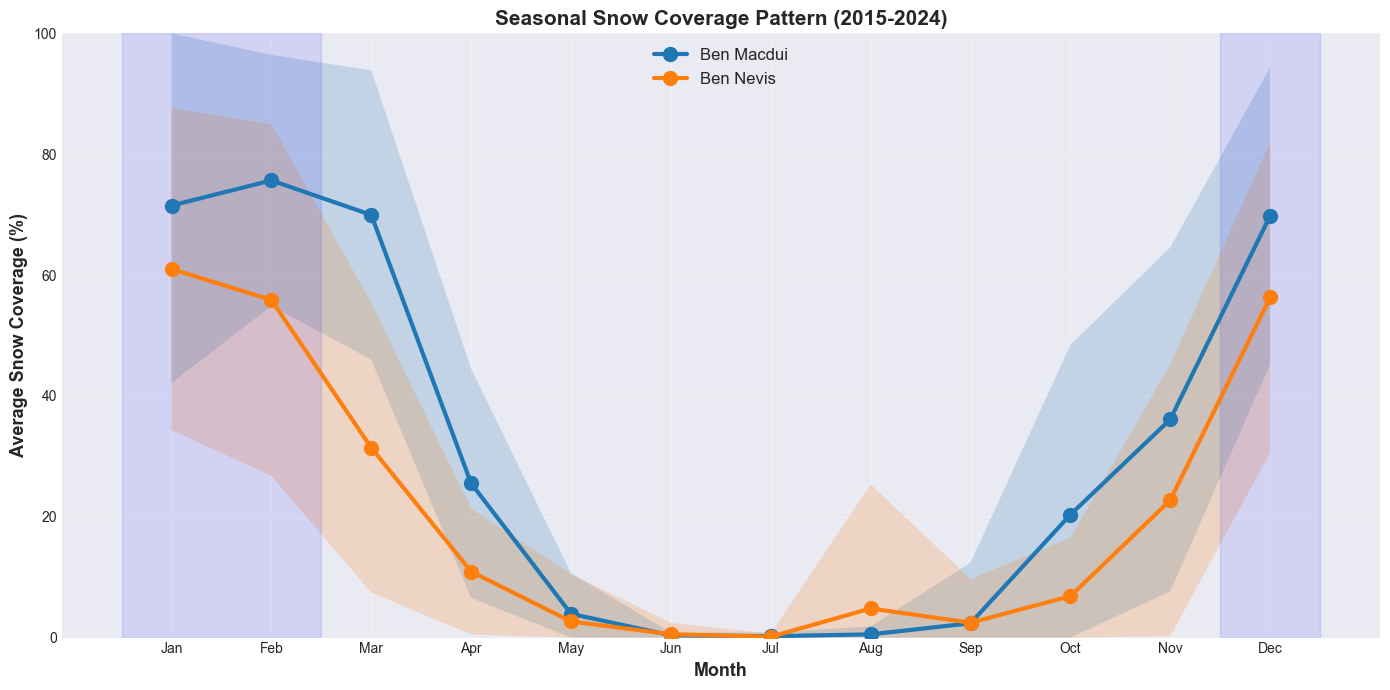

In [16]:
if len(trends_df) > 0:
    # Monthly averages
    monthly_avg = trends_df.groupby(['aoi_name', 'month']).agg({
        'snow_pct': ['mean', 'std', 'count']
    }).round(2)
    
    print("\nAverage Snow Coverage by Month (2015-2024):")
    print(monthly_avg)
    
    # Plot monthly averages
    fig, ax = plt.subplots(figsize=(14, 7))
    
    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                   'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    
    for aoi_name in sorted(trends_df['aoi_name'].unique()):
        aoi_data = trends_df[trends_df['aoi_name'] == aoi_name]
        monthly_means = aoi_data.groupby('month')['snow_pct'].mean()
        monthly_std = aoi_data.groupby('month')['snow_pct'].std()
        
        ax.plot(monthly_means.index, monthly_means.values, marker='o', 
                linewidth=3, markersize=10, label=aoi_name)
        ax.fill_between(monthly_means.index, 
                        (monthly_means - monthly_std).clip(lower=0),
                        (monthly_means + monthly_std).clip(upper=100),
                        alpha=0.2)
    
    ax.set_xlabel('Month', fontsize=13, fontweight='bold')
    ax.set_ylabel('Average Snow Coverage (%)', fontsize=13, fontweight='bold')
    ax.set_title('Seasonal Snow Coverage Pattern (2015-2024)', fontsize=15, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=12)
    ax.set_xticks(range(1, 13))
    ax.set_xticklabels(month_names)
    ax.set_ylim(0, 100)
    
    # Highlight winter months
    ax.axvspan(11.5, 12.5, alpha=0.1, color='blue')
    ax.axvspan(0.5, 2.5, alpha=0.1, color='blue')
    
    plt.tight_layout()
    plt.show()
else:
    print("No data available")

## 12. Summary Statistics

Comprehensive statistics across the decade.

In [17]:
if len(trends_df) > 0:
    # Overall summary
    print("\nOVERALL SUMMARY (2015-2024):\n")
    
    overall_summary = trends_df.groupby('aoi_name').agg({
        'snow_pct': ['mean', 'std', 'min', 'max'],
        'cloud_cover': 'mean',
        'date': 'count'
    }).round(2)
    
    print(overall_summary)
    print()
    
    # Seasonal summary
    def get_season(month):
        if month in [12, 1, 2]:
            return 'Winter'
        elif month in [3, 4, 5]:
            return 'Spring'
        elif month in [6, 7, 8]:
            return 'Summer'
        else:
            return 'Autumn'
    
    trends_df['season'] = trends_df['month'].apply(get_season)
    
    seasonal_summary = trends_df.groupby(['aoi_name', 'season']).agg({
        'snow_pct': ['mean', 'std', 'count']
    }).round(2)
    
    print("\nSeasonal Summary:")
    print(seasonal_summary)
else:
    print("No data available")


OVERALL SUMMARY (2015-2024):

           snow_pct                     cloud_cover  date
               mean    std  min     max        mean count
aoi_name                                                 
Ben Macdui    36.41  37.13  0.0  100.00       28.23   233
Ben Nevis     22.12  28.91  0.0   99.77       26.55   416


Seasonal Summary:
                  snow_pct             
                      mean    std count
aoi_name   season                      
Ben Macdui Autumn    17.80  26.41    58
           Spring    38.63  33.75    60
           Summer     0.35   0.78    44
           Winter    72.10  25.32    71
Ben Nevis  Autumn    12.19  18.36   106
           Spring    15.07  19.51   127
           Summer     1.40   9.95    82
           Winter    58.24  26.78   101


## Conclusion

This notebook provides a comprehensive 10-year analysis of snow coverage in the Scottish Highlands.

### Key Capabilities:
1. ✓ Year-round data from 2015-2024 (Sentinel-2 era)
2. ✓ NDSI-based snow classification
3. ✓ **Statistical trend analysis with significance testing**
4. ✓ **Clear determination of whether snow is increasing or decreasing**
5. ✓ Seasonal breakdown (winter vs summer trends)
6. ✓ Distribution analysis and variability assessment

### How to Interpret Results:

**Section 8** contains the main answer to "Is snow increasing or decreasing?":
- Look at the **slope** of the trend line (positive = increasing, negative = decreasing)
- Check the **p-value** (< 0.05 means the trend is statistically significant)
- Review **R²** value (closer to 1 means stronger linear relationship)
- Note the **total change** over the decade

The analysis accounts for:
- Natural year-to-year variability
- Seasonal differences
- Statistical confidence levels
- Long-term trends vs short-term fluctuations

In [18]:
# Close database session
session.close()
print("✓ Database session closed")

✓ Database session closed
